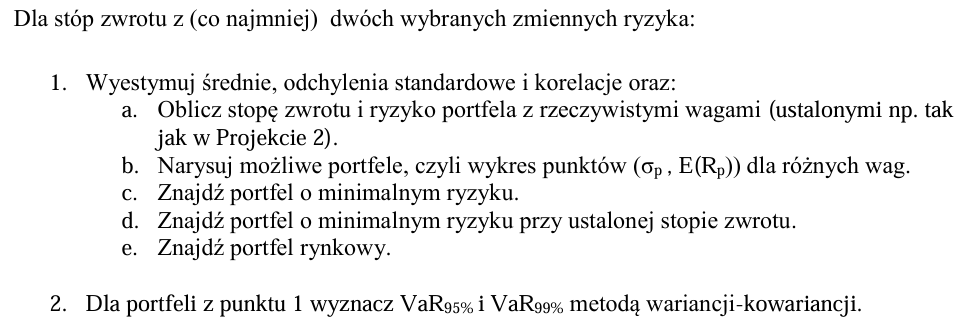

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize_scalar

In [2]:
# Wczytaj plik
df1 = pd.read_csv('fuel_output.csv', sep=';')
df2 = pd.read_csv('merged_output.csv', sep=';')
# WyodrÄ™bnij kolumny do zmiennych
#dates = pd.to_datetime(df['Date'])

fuel_data = df1['fuel_data']
beef_data=df2['beef_data']

fuel_returns = np.log(fuel_data / fuel_data.shift(1)).dropna()
beef_returns = np.log(beef_data / beef_data.shift(1)).dropna()



# 1. Statystyki

In [3]:
### PALIWO
mean_returns_f = fuel_returns.mean()
std_devs_f = fuel_returns.std()
#cov_matrix = fuel_returns.cov()
#correlation = fuel_returns.corr()

print("Åšrednie stopy zwrotu:\n", mean_returns_f)
print("\nOdchylenia standardowe:\n", std_devs_f)


Åšrednie stopy zwrotu:
 0.0010584922842003712

Odchylenia standardowe:
 0.01686179481992683


In [4]:
### WOLOWINA
mean_returns_b = beef_returns.mean()
std_devs_b = beef_returns.std()

print("Åšrednie stopy zwrotu:\n", mean_returns_b)
print("\nOdchylenia standardowe:\n", std_devs_b)


Åšrednie stopy zwrotu:
 -0.00014511107802290383

Odchylenia standardowe:
 0.027503848821220696


In [5]:
# KORELACJA MIEDZY NIMI
correlation = np.corrcoef(beef_returns,fuel_returns)
print(correlation)

[[1.         0.00780695]
 [0.00780695 1.        ]]


## a) stopa zwrotu i ryzyko portfela

In [6]:
cov_matrix=np.cov([beef_returns, fuel_returns])
### TO DODALAM MINUSY  
mean_returns=np.array([mean_returns_b, mean_returns_f])
std_devs=np.array([std_devs_b, std_devs_f])

weights = np.array([0.5, 0.5]) 
port_return = np.dot(weights, mean_returns)
port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print(f"Stopa zwrotu portfela: {port_return:.4f}")
print(f"Ryzyko portfela (Ïƒ): {port_std:.4f}")


Stopa zwrotu portfela: 0.0005
Ryzyko portfela (Ïƒ): 0.0162


## b) wykres z wagami

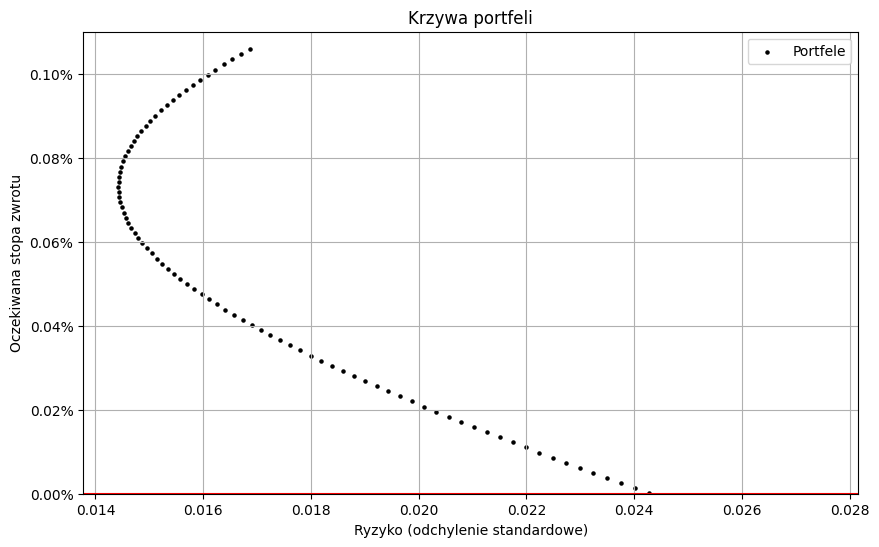

In [7]:
from matplotlib.ticker import FuncFormatter

weights_range = np.linspace(0, 1, 100)
returns_list = []
stds_list = []

for w in weights_range:
    w_vec = np.array([w, 1-w])
    r = np.dot(w_vec, mean_returns)
    s = np.sqrt(np.dot(w_vec.T, np.dot(cov_matrix, w_vec)))
    returns_list.append(r)
    stds_list.append(s)

# plt.figure(figsize=(10, 6))
# plt.scatter(stds_list, returns_list, s=5, color = "black", label="Portfele")
# plt.xlabel("Ryzyko (odchylenie standardowe)")
# plt.ylabel("Oczekiwana stopa zwrotu")
# plt.title("Krzywa portfeli")
# plt.ylim(0,0.0011)
# plt.axhline(y=0, color='red')
# plt.grid(True)
# plt.legend()
# plt.show()
from matplotlib.ticker import FuncFormatter

def to_percent(y, _):
    return f'{y * 100:.2f}%'

plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, s=5, color="black", label="Portfele")
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.ylim(0, 0.0011)
plt.axhline(y=0, color='red')
plt.grid(True)
plt.legend()

# Formatowanie osi y jako procenty
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()


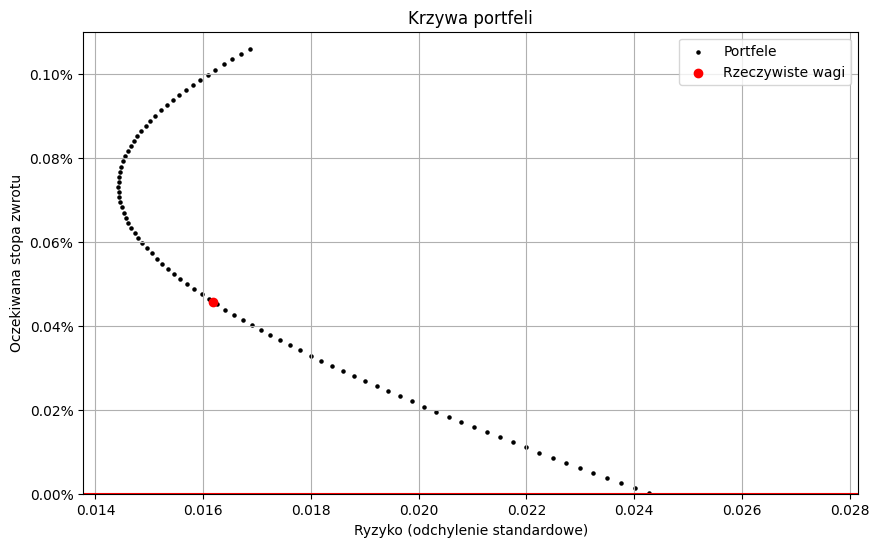

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, s=5, color = "black", label="Portfele")
plt.scatter(port_std, port_return, color='red', label='Rzeczywiste wagi', zorder=5)
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.ylim(0,0.0011)
plt.axhline(y=0, color='red')
plt.grid(True)
plt.legend()
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()


## c) minimalne ryzyko

In [9]:
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))
w_min_var = np.dot(inv_cov, ones) / np.dot(ones.T, np.dot(inv_cov, ones))

print("Wagi portfela minimalnego ryzyka:", w_min_var)


Wagi portfela minimalnego ryzyka: [0.27159023 0.72840977]


In [10]:
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

# wagi portfela minimalnego ryzyka
w_min_var = np.dot(inv_cov, ones) / np.dot(ones.T, np.dot(inv_cov, ones))

# stopa zwrotu i ryzyko tego portfela
r_min_var = np.dot(w_min_var, mean_returns)
std_min_var = np.sqrt(np.dot(w_min_var.T, np.dot(cov_matrix, w_min_var)))

print("Stopa zwrotu portfela o minimalnym ryzyku:", r_min_var)
print("Odchylenie standardowe portfela o minimalnym ryzyku:", std_min_var)


Stopa zwrotu portfela o minimalnym ryzyku: 0.0007316053756844118
Odchylenie standardowe portfela o minimalnym ryzyku: 0.014425147257820958


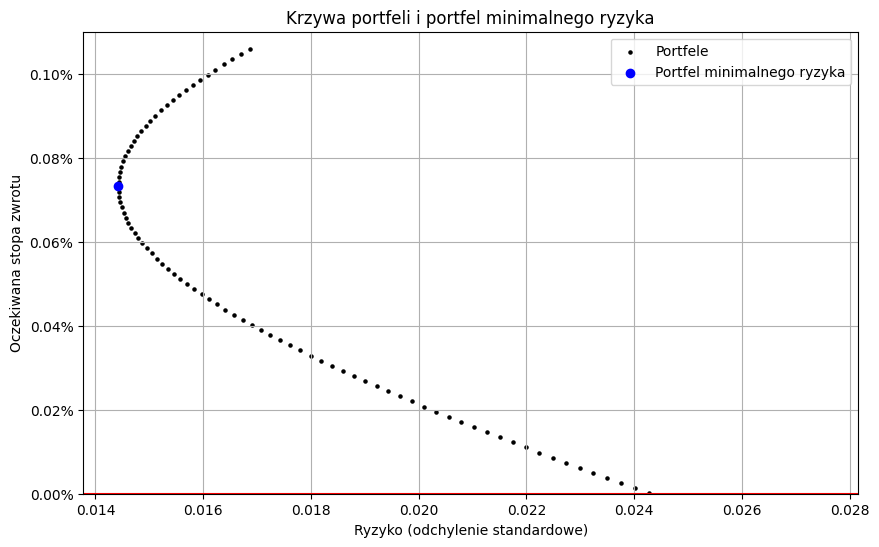

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, color='black', s=5, label="Portfele")
plt.scatter(std_min_var, r_min_var, color='blue', label='Portfel minimalnego ryzyka', zorder=5)
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli i portfel minimalnego ryzyka")
plt.grid(True)
plt.ylim(0,0.0011)
plt.legend()
plt.axhline(y=0, color='red')
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()



## d) minimalne ryzyko przy ustalonej stopie zwrotu

In [12]:

### TO NA PLUSIE CZY NA MINUSIE????
target_return = 0.001

A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

lambda_1 = (C * target_return - B) / D
lambda_2 = (A - B * target_return) / D

w_target = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
print("Wagi portfela dla ustalonej stopy zwrotu:", w_target)

Wagi portfela dla ustalonej stopy zwrotu: [0.04859764 0.95140236]


In [13]:
print("Dla wag 1 i 0 (ten czubek)")
print("sigma:",stds_list[0])
print("zwrot:", returns_list[0])

Dla wag 1 i 0 (ten czubek)
sigma: 0.01686179481992683
zwrot: 0.0010584922842003712


Wyniki dla stÃ³p od 0.0008 do 0.001 co 0.00005

In [14]:
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
risks = []
weights_1 = [] 
weights_2 = []

A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

for target_return in target_returns:
    lambda_1 = (C * target_return - B) / D
    lambda_2 = (A - B * target_return) / D

    w = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
    sigma = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    risks.append(sigma)
    weights_1.append(w[0])
    weights_2.append(w[1])

In [15]:
# Tworzenie DataFrame
df_portfele = pd.DataFrame({
    'Oczekiwana stopa zwrotu': target_returns,
    'Ryzyko (odchylenie standardowe)': risks,
    'Waga woÅ‚owiny': weights_1,
    'Waga paliwa': weights_2
})

df_portfele

Oczekiwana stopa zwrotu  Ryzyko (odchylenie standardowe)  Waga woÅ‚owiny  \
0                 -0.000145                         0.027504   1.000000e+00   
1                 -0.000133                         0.027228   9.898990e-01   
2                 -0.000121                         0.026953   9.797980e-01   
3                 -0.000109                         0.026679   9.696970e-01   
4                 -0.000096                         0.026407   9.595960e-01   
..                      ...                              ...            ...   
95                 0.001010                         0.016227   4.040404e-02   
96                 0.001022                         0.016379   3.030303e-02   
97                 0.001034                         0.016535   2.020202e-02   
98                 0.001046                         0.016696   1.010101e-02   
99                 0.001058                         0.016862   1.318390e-16   

    Waga paliwa  
0      0.000000  
1      0.010101  
2      0.020202  
3      0.030303  
4      0.040404  
..          ...  
95     0.959596  
96     0.969697  
97     0.979798  
98     0.989899  
99     1.000000  

[100 rows x 4 columns]

DLa Å›redniej stopy zwrottu dla portfeli efektywnych

In [16]:
mean_returns_effective = np.mean([r for r in returns_list if r > r_min_var])
lambda_1 = (C * mean_returns_effective - B) / D
lambda_2 = (A - B * mean_returns_effective) / D

w_mean_returns_effective = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
sigma_mean_returns_effective = np.sqrt(np.dot(w_mean_returns_effective.T, np.dot(cov_matrix, w_mean_returns_effective)))

print("Åšrednia stopa zwrotu dla efektywnych portfeli:", mean_returns_effective)
print("Wagi portfela dla ustalonej stopy zwrotu:", w_mean_returns_effective)

Åšrednia stopa zwrotu dla efektywnych portfeli: 0.00090044335784782
Wagi portfela dla ustalonej stopy zwrotu: [0.13131313 0.86868687]


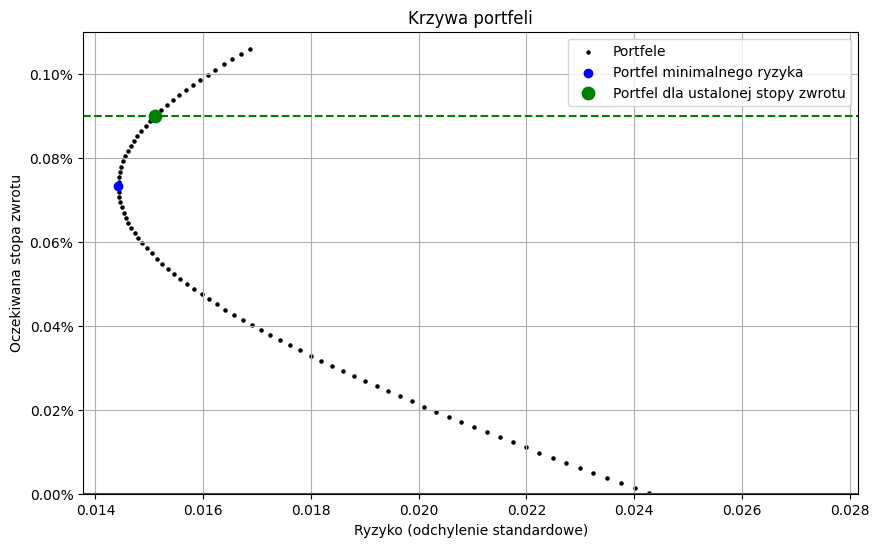

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, color='black', s=5, label="Portfele")
plt.scatter(std_min_var, r_min_var, color='blue', label='Portfel minimalnego ryzyka', zorder=5)
plt.scatter(sigma_mean_returns_effective, mean_returns_effective, color = "green", s = 80, label = "Portfel dla ustalonej stopy zwrotu")
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.grid(True)
plt.legend()
plt.ylim(0,0.0011)
plt.axhline(y=0, color='red')
plt.axhline( y=mean_returns_effective, color='green', linestyle='--', label=f"Ustalona stopa zwrotu = {mean_returns_effective:.6f}")
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()


## e) stopa wolna rynkowa 

In [18]:
returns = pd.concat([beef_returns, fuel_returns], axis=1)
#returns.columns = ['beef', 'fuel']  # nadaj nazwy, jeÅ›li ich brak

# Teraz policz Å›rednie i odchylenia jako Series z nazwami
mean_returns = returns.mean()
std_devs = returns.std()


In [19]:
mean_returns

beef_data   -0.000145
fuel_data    0.001058
dtype: float64

In [20]:
r_f = -0.001

excess_returns = mean_returns - r_f
sharpe_ratios =pd.Series(excess_returns / std_devs)

# Portfel rynkowy = maksymalny wskaÅºnik Sharpe'a
best_idx = sharpe_ratios.idxmax()
print(f"Najlepszy skÅ‚adnik portfela rynkowego: {best_idx}")


Najlepszy skÅ‚adnik portfela rynkowego: fuel_data


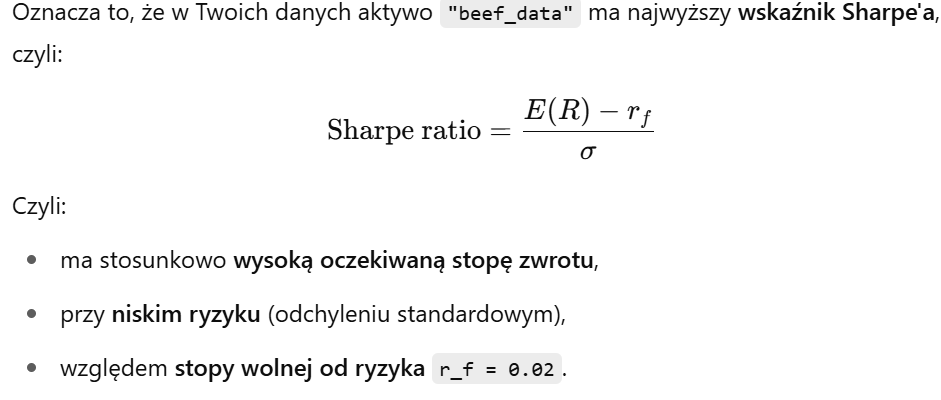

In [21]:
import numpy as np

# StaÅ‚e
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

# Tangency portfolio (maksymalny Sharpe ratio)
excess = mean_returns - r_f
numerator = np.dot(inv_cov, excess)
denominator = np.dot(ones.T, numerator)
w_market = numerator / denominator
# w_market = np.array([0.13,0.87])
# Parametry portfela rynkowego
R_market = np.dot(w_market, mean_returns)
Ïƒ_market = np.sqrt(np.dot(w_market.T, np.dot(cov_matrix, w_market)))

print(f"Portfel rynkowy:\nWagi: {w_market}\nOczekiwana stopa zwrotu: {R_market:.4f}\nRyzyko: {Ïƒ_market:.4f}")


Portfel rynkowy:
Wagi: [0.13164844 0.86835156]
Oczekiwana stopa zwrotu: 0.0009
Ryzyko: 0.0151


In [22]:
### MOJE
# sharpe_market = (R_market - r_f) / Ïƒ_market
# print(f"r_f = {r_f:.6f}")
# print(f"R_market = {R_market:.6f}")
# print(f"Ïƒ_market = {Ïƒ_market:.6f}")
# print(f"Sharpe ratio = {sharpe_market:.2f}")


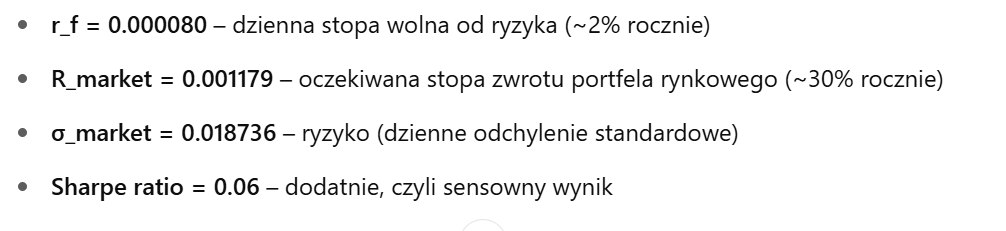

In [23]:
sharpe_market = (R_market - r_f) / Ïƒ_market
print(f"WskaÅºnik Sharpeâ€™a portfela rynkowego: {sharpe_market:.4f}")

WskaÅºnik Sharpeâ€™a portfela rynkowego: 0.1257


In [24]:
import numpy as np
from scipy.optimize import minimize

def sharpe_ratio_neg(w, mean_returns, cov_matrix, r_f):
    port_return = np.dot(w, mean_returns)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return - (port_return - r_f) / port_vol  # negatywny Sharpe

def optimize_portfolio(mean_returns, cov_matrix, r_f):
    num_assets = len(mean_returns)
    bounds = [(0, 1)] * num_assets  # bez shortÃ³w
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # suma wag = 1
    initial_guess = np.ones(num_assets) / num_assets  # rÃ³wny start

    result = minimize(sharpe_ratio_neg, initial_guess,
                      args=(mean_returns, cov_matrix, r_f),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    return result.x  # optymalne wagi

# PrzykÅ‚ad uÅ¼ycia:
# w_tangency = optimize_portfolio(mean_returns, cov_matrix, r_f)
# print("Wagi bez shortÃ³w:", w_tangency)


In [25]:
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)


risks = []
A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

risks = []
for R_target in target_returns:
    Î»1 = (C * R_target - B) / D
    Î»2 = (A - B * R_target) / D
    w = Î»1 * np.dot(inv_cov, mean_returns) + Î»2 * np.dot(inv_cov, ones)
    Ïƒ = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    risks.append(Ïƒ)



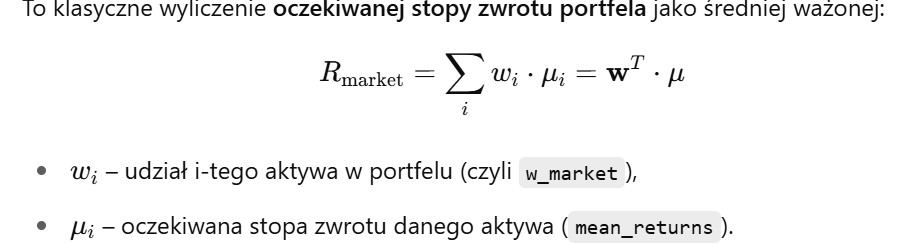

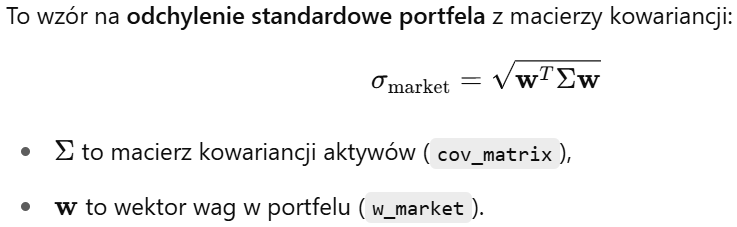

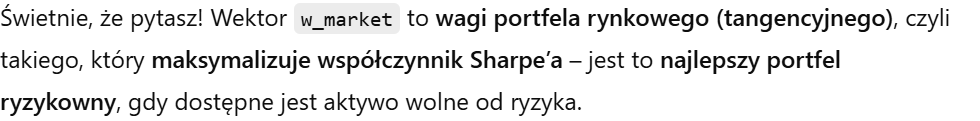

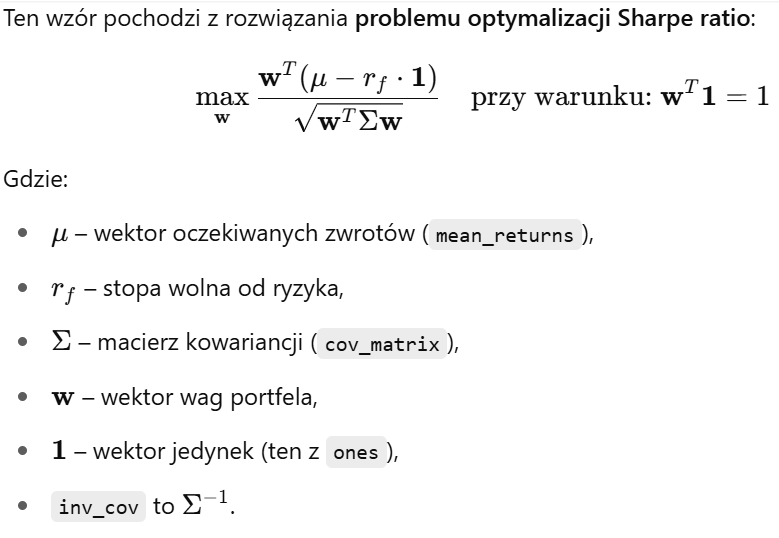

In [26]:
import numpy as np
from scipy.optimize import minimize

def sharpe_ratio_neg(w, mean_returns, cov_matrix, r_f):
    port_return = np.dot(w, mean_returns)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return - (port_return - r_f) / port_vol  # negatywny Sharpe

def optimize_portfolio(mean_returns, cov_matrix, r_f):
    num_assets = len(mean_returns)
    bounds = [(0, 1)] * num_assets  # bez shortÃ³w
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # suma wag = 1
    initial_guess = np.ones(num_assets) / num_assets  # rÃ³wny start

    result = minimize(sharpe_ratio_neg, initial_guess,
                      args=(mean_returns, cov_matrix, r_f),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    return result.x  # optymalne wagi

# PrzykÅ‚ad uÅ¼ycia:
# w_tangency = optimize_portfolio(mean_returns, cov_matrix, r_f)
# print("Wagi bez shortÃ³w:", w_tangency)


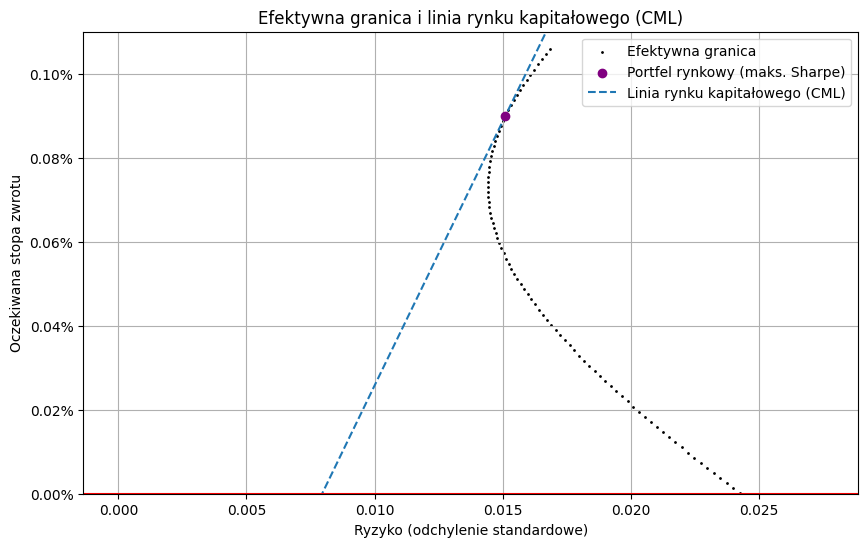

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Efektywna granica
plt.scatter(risks, target_returns, color = "black", s = 1, label='Efektywna granica')

# Portfel rynkowy (tangency point)
plt.scatter(Ïƒ_market, R_market, color='purple', label='Portfel rynkowy (maks. Sharpe)', zorder=5)

# CML â€“ linia rynku kapitaÅ‚owego
Ïƒ_cml = np.linspace(0, max(risks), 100)
R_cml = r_f + (R_market - r_f) / Ïƒ_market * Ïƒ_cml
plt.plot(Ïƒ_cml, R_cml, label='Linia rynku kapitaÅ‚owego (CML)', linestyle='--')

# Oznaczenia
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Efektywna granica i linia rynku kapitaÅ‚owego (CML)")
plt.ylim(0,0.0011)
# plt.xlim(0.013,0.03)
plt.axhline(y=0, color='red')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()



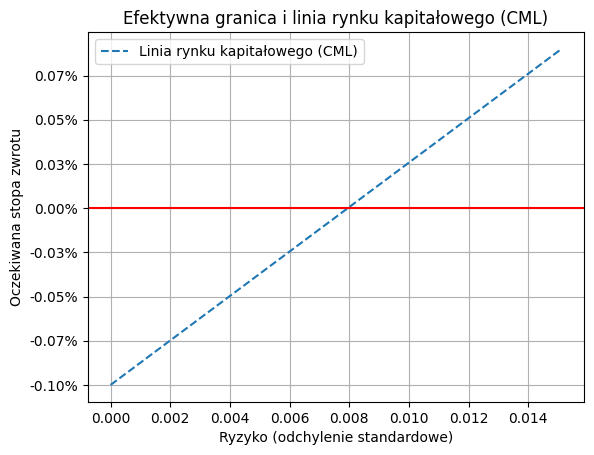

In [28]:
sharpe_ratios = [(R - r_f) / Ïƒ for R, Ïƒ in zip(target_returns, risks)]
i_max = np.argmax(sharpe_ratios)
R_market = target_returns[i_max]
Ïƒ_market = risks[i_max]
Ïƒ_cml = np.linspace(0, Ïƒ_market, 100)
R_cml = r_f + (R_market - r_f) / Ïƒ_market * Ïƒ_cml


plt.plot(Ïƒ_cml, R_cml, label='Linia rynku kapitaÅ‚owego (CML)', linestyle='--')

# Oznaczenia
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Efektywna granica i linia rynku kapitaÅ‚owego (CML)")
# plt.ylim(0,0.0011)
# plt.xlim(0.013,0.03)
plt.axhline(y=0, color='red')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()


In [29]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

R=
sharpe_ratios = [(R - r_f) / Ïƒ for R, Ïƒ in zip(target_returns, risks)]
i_max = np.argmax(sharpe_ratios)
R_market = target_returns[i_max]
Ïƒ_market = risks[i_max]

# Linia CML
Ïƒ_cml = np.linspace(0, Ïƒ_market, 100)
R_cml = r_f + (R_market - r_f) / Ïƒ_market * Ïƒ_cml

# Wykres
plt.figure(figsize=(10, 6))

# Efektywna granica
plt.plot(risks, target_returns, 'k.', markersize=2, label='Efektywna granica')

# Punkt portfela rynkowego
plt.scatter(Ïƒ_market, R_market, color='purple', s=60, label='Portfel rynkowy (maks. Sharpe)', zorder=5)

# Linia rynku kapitaÅ‚owego (CML)
plt.plot(Ïƒ_cml, R_cml, linestyle='--', label='Linia rynku kapitaÅ‚owego (CML)')

# Oznaczenia osi, legenda, siatka
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Efektywna granica i linia rynku kapitaÅ‚owego (CML)")
plt.axhline(y=0, color='red', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2%}'))

plt.show()


SyntaxError: invalid syntax (3486989256.py, line 5)

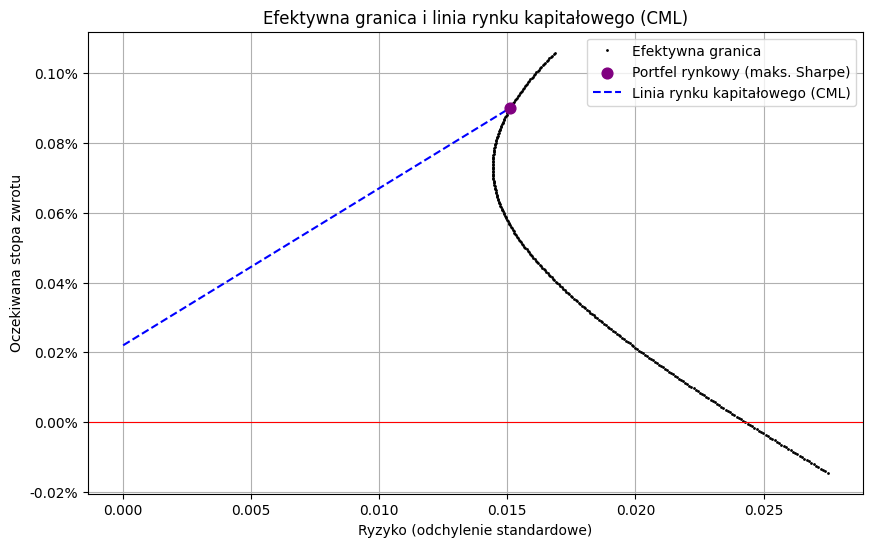

In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

# ZakÅ‚adamy, Å¼e masz wczeÅ›niej obliczone: risks, target_returns, weights_list

# StopÄ™ wolnÄ… od ryzyka przyjmujemy na podstawie bieÅ¼Ä…cej rentownoÅ›ci obligacji skarbowych:
r_f = 0.00022  # 0.022% dziennie (~5.5% rocznie)

# Wyznaczenie Sharpe ratio dla kaÅ¼dego portfela na efektywnej granicy


r_f = 0.00022 
best_weights=[0.1313, 0.8686]
R_market = np.dot(best_weights, mean_returns)
sigma = np.sqrt(np.dot(np.array(best_weights).T, np.dot(cov_matrix, best_weights)))

ratio=(R_market-r_f)/sigma
# Linia rynku kapitaÅ‚owego (CML)
Ïƒ_cml = np.linspace(0, sigma, 100)
R_cml = r_f + (R_market - r_f) / sigma

# Wykres
plt.figure(figsize=(10, 6))

# Efektywna granica
plt.plot(risks, target_returns, 'k.', markersize=2, label='Efektywna granica')

# Punkt portfela rynkowego
plt.scatter(sigma, R_market, color='purple', s=60, label='Portfel rynkowy (maks. Sharpe)', zorder=5)

# Linia rynku kapitaÅ‚owego (CML)
# plt.plot(Ïƒ_cml, R_cml, linestyle='--', label='Linia rynku kapitaÅ‚owego (CML)')
# Linia CML â€“ styczna w punkcie (sigma, R_market)
Ïƒ_cml = np.linspace(0, sigma, 100)
R_cml = r_f + (R_market - r_f) / sigma * Ïƒ_cml
plt.plot(Ïƒ_cml, R_cml, linestyle='--', color='blue', label='Linia rynku kapitaÅ‚owego (CML)')

# Oznaczenia osi, legenda, siatka
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Efektywna granica i linia rynku kapitaÅ‚owego (CML)")
plt.axhline(y=0, color='red', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2%}'))

plt.show()

# Wypisanie parametrÃ³w portfela rynkowego
# print("ðŸ”¹ Portfel maksymalnego Sharpe'a:")
# print(f"- Oczekiwana stopa zwrotu: {R_market:.6f} ({R_market:.2%})")
# print(f"- Ryzyko (odchylenie standardowe): {Ïƒ_market:.6f} ({Ïƒ_market:.2%})")
# print(f"- WskaÅºnik Sharpeâ€™a: {best_sharpe:.4f}")
# print("- Wagi portfela:")

# for asset, weight in zip(returns.columns, best_weights):
#     print(f"  â€¢ {asset}: {weight:.4%}")


In [ ]:
R_market = np.dot(best_weights, mean_returns)
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 10000)


risks = []
A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

risks = []
for R_target in target_returns:
    Î»1 = (C * R_target - B) / D
    Î»2 = (A - B * R_target) / D
    w = Î»1 * np.dot(inv_cov, mean_returns) + Î»2 * np.dot(inv_cov, ones)
    Ïƒ = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    risks.append(Ïƒ)

0.0009004433578478199


In [ ]:
import numpy as np
import pandas as pd

# ZakÅ‚adam, Å¼e masz wczeÅ›niej zdefiniowane:
# mean_returns (np.array), cov_matrix (np.array), returns.columns

inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 300)
risks = []
weights_list = []

for R_target in target_returns:
    Î»1 = (C * R_target - B) / D
    Î»2 = (A - B * R_target) / D
    w = Î»1 * np.dot(inv_cov, mean_returns) + Î»2 * np.dot(inv_cov, ones)
    sigma = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    
    weights_list.append(w)
    risks.append(sigma)

# Tworzymy DataFrame z wagami, ryzykiem i zwrotami
df = pd.DataFrame(weights_list, columns=returns.columns)
df["return"] = target_returns
df["risk"] = risks

# Grupujemy po ryzyku zaokrÄ…glonym do np. 4 miejsc i bierzemy maksimum zwrotu
df["risk_rounded"] = df["risk"].round(4)
df_upper = df.loc[df.groupby("risk_rounded")["return"].idxmax()].reset_index(drop=True)

# WyÅ›wietlamy wagi dla gÃ³rnego ramienia
print("ðŸ”¹ Wagi portfeli z gÃ³rnego ramienia efektywnej granicy:\n")
for i, row in df_upper.iterrows():
    weights = [f"{asset}: {row[asset]:.4%}" for asset in returns.columns]
    print(f"Portfel {i+1:2d} | Ryzyko: {row['risk']:.4f} | Zwrot: {row['return']:.4f} â†’ {weights}")


ðŸ”¹ Wagi portfeli z gÃ³rnego ramienia efektywnej granicy:

Portfel  1 | Ryzyko: 0.0144 | Zwrot: 0.0008 â†’ ['0: 24.7492%', '1: 75.2508%', '2: 0.0761%', '3: 1.4446%', '4: 1.4400%']
Portfel  2 | Ryzyko: 0.0145 | Zwrot: 0.0008 â†’ ['0: 21.4047%', '1: 78.5953%', '2: 0.0801%', '3: 1.4543%', '4: 1.4500%']
Portfel  3 | Ryzyko: 0.0146 | Zwrot: 0.0008 â†’ ['0: 19.3980%', '1: 80.6020%', '2: 0.0825%', '3: 1.4639%', '4: 1.4600%']
Portfel  4 | Ryzyko: 0.0147 | Zwrot: 0.0008 â†’ ['0: 17.7258%', '1: 82.2742%', '2: 0.0845%', '3: 1.4740%', '4: 1.4700%']
Portfel  5 | Ryzyko: 0.0148 | Zwrot: 0.0009 â†’ ['0: 16.3880%', '1: 83.6120%', '2: 0.0861%', '3: 1.4835%', '4: 1.4800%']
Portfel  6 | Ryzyko: 0.0149 | Zwrot: 0.0009 â†’ ['0: 15.0502%', '1: 84.9498%', '2: 0.0877%', '3: 1.4941%', '4: 1.4900%']
Portfel  7 | Ryzyko: 0.0150 | Zwrot: 0.0009 â†’ ['0: 14.0468%', '1: 85.9532%', '2: 0.0889%', '3: 1.5028%', '4: 1.5000%']
Portfel  8 | Ryzyko: 0.0151 | Zwrot: 0.0009 â†’ ['0: 13.0435%', '1: 86.9565%', '2: 0.0902%', 

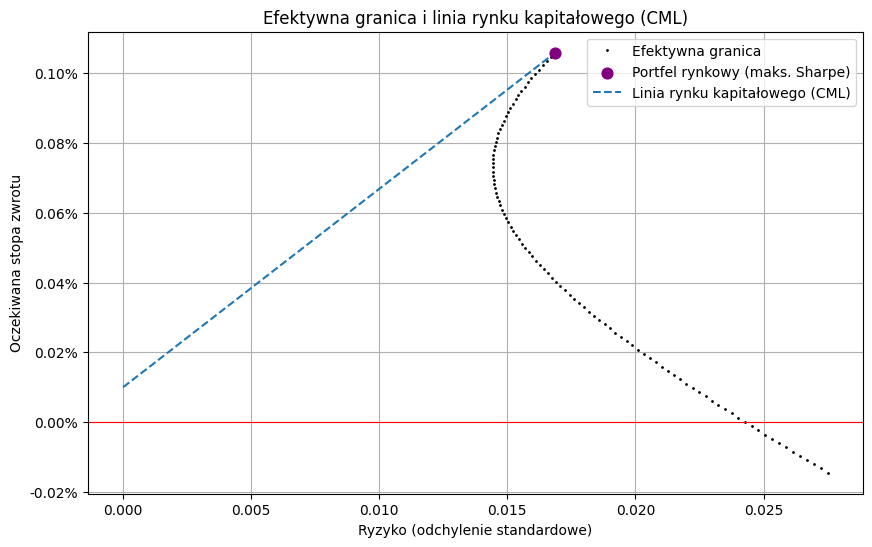

ðŸ”¹ Portfel maksymalnego Sharpe'a:
- Oczekiwana stopa zwrotu: 0.001058 (0.11%)
- Ryzyko (odchylenie standardowe): 0.016862 (1.69%)
- WskaÅºnik Sharpeâ€™a: 0.0568
- Wagi portfela:
  â€¢ beef_data: 0.0000%
  â€¢ fuel_data: 100.0000%


In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

# ZakÅ‚adamy, Å¼e masz:
# mean_returns, cov_matrix, returns

r_f = 0.0001  # dzienna stopa wolna od ryzyka (~5.5% rocznie)

inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

excess = mean_returns - r_f
numerator = np.dot(inv_cov, excess)
denominator = np.dot(ones.T, numerator)
w_market = numerator / denominator

# Parametry portfela rynkowego
R_market = np.dot(w_market, mean_returns)
Ïƒ_market = np.sqrt(np.dot(w_market.T, np.dot(cov_matrix, w_market)))






A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
risks = []
weights_list = []

for R_target in target_returns:
    Î»1 = (C * R_target - B) / D
    Î»2 = (A - B * R_target) / D
    w = Î»1 * np.dot(inv_cov, mean_returns) + Î»2 * np.dot(inv_cov, ones)
    Ïƒ = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    weights_list.append(w)
    risks.append(Ïƒ)

# Wyznaczenie portfela maksymalnego Sharpeâ€™a
sharpe_ratios = [(R - r_f) / Ïƒ for R, Ïƒ in zip(target_returns, risks)]
i_max = np.argmax(sharpe_ratios)
R_market = target_returns[i_max]
Ïƒ_market = risks[i_max]
best_weights = weights_list[i_max]
best_sharpe = sharpe_ratios[i_max]
R_market = np.dot(best_weights, mean_returns)

# Linia rynku kapitaÅ‚owego (CML)
Ïƒ_cml = np.linspace(0, Ïƒ_market, 100)
R_cml = r_f + (R_market - r_f) / Ïƒ_market * Ïƒ_cml







# Wykres
plt.figure(figsize=(10, 6))

plt.plot(risks, target_returns, 'k.', markersize=2, label='Efektywna granica')
plt.scatter(Ïƒ_market, R_market, color='purple', s=60, label='Portfel rynkowy (maks. Sharpe)', zorder=5)
plt.plot(Ïƒ_cml, R_cml, linestyle='--', label='Linia rynku kapitaÅ‚owego (CML)')

plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Efektywna granica i linia rynku kapitaÅ‚owego (CML)")
plt.axhline(y=0, color='red', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2%}'))

plt.show()

# Wyniki
print("ðŸ”¹ Portfel maksymalnego Sharpe'a:")
print(f"- Oczekiwana stopa zwrotu: {R_market:.6f} ({R_market:.2%})")
print(f"- Ryzyko (odchylenie standardowe): {Ïƒ_market:.6f} ({Ïƒ_market:.2%})")
print(f"- WskaÅºnik Sharpeâ€™a: {best_sharpe:.4f}")
print("- Wagi portfela:")

for asset, weight in zip(returns.columns, best_weights):
    print(f"  â€¢ {asset}: {weight:.4%}")


Podsumowanie

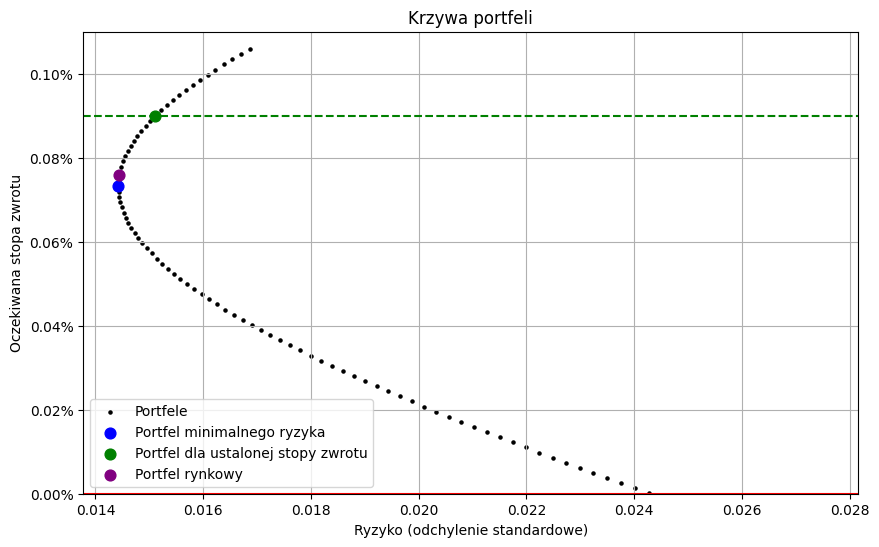

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, color='black', s=5, label="Portfele")
plt.scatter(std_min_var, r_min_var, color='blue', s = 60, label='Portfel minimalnego ryzyka')
plt.scatter(sigma_mean_returns_effective, mean_returns_effective, color = "green", s = 60, label = "Portfel dla ustalonej stopy zwrotu")
plt.scatter(Ïƒ_market, R_market, color = "purple", s = 60, label = "Portfel rynkowy")
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.grid(True)
plt.legend()
plt.ylim(0,0.0011)
plt.axhline(y=0, color='red')
plt.axhline( y=mean_returns_effective, color='green', linestyle='--', label=f"Ustalona stopa zwrotu = {mean_returns_effective:.6f}")
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()


# 2.

In [ ]:
#Macierz kowariancji
cov_matrix = returns.cov()
print(cov_matrix)

           beef_data  fuel_data
beef_data   0.000756   0.000004
fuel_data   0.000004   0.000284


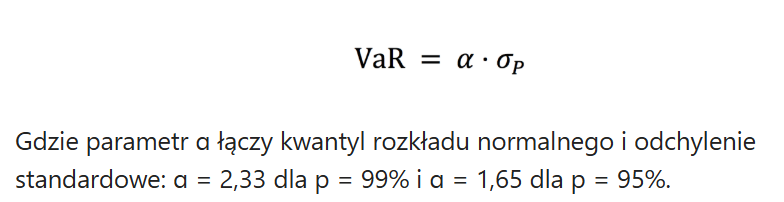

In [ ]:
def VaR(w):
    sigma_p = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    z_95 = norm.ppf(0.95)
    z_99 = norm.ppf(0.99)

    VaR_95 = z_95*sigma_p
    VaR_99 = z_99*sigma_p

    return(VaR_95, VaR_99)

In [ ]:
VaR_rzeczywiste = VaR(weights)
VaR_min_var = VaR(w_min_var)
VaR_mean_returns_effective = VaR(w_mean_returns_effective)
VaR_market = VaR(w_market)

In [ ]:
data = {
    '': ['VaR95', 'VaR99'],
    'Rzeczywisty': VaR_rzeczywiste,
    'Minimalnego ryzyka': VaR_min_var,
    'Ustalona stopa zwrotu': VaR_mean_returns_effective,
    'Rynkowy': VaR_market
}

df_VaR = pd.DataFrame(data)
df_VaR

Rzeczywisty  Minimalnego ryzyka  Ustalona stopa zwrotu   Rynkowy
0  VaR95     0.026625            0.023727                0.02486  0.023737
1  VaR99     0.037656            0.033558                0.03516  0.033571